# Tutorial 4

In this tutorial we'll look at graphs and learning on them using neural networks.

In [1]:
import numpy as np
import math

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

import torch
from torch.nn import Module
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

print("PyTorch version:", torch.__version__)
print("PyTorch geometric version:", torch_geometric.__version__)

PyTorch version: 2.8.0+cu128
PyTorch geometric version: 2.6.1


## Finding an embedding with node2vec

To find an embedding we make 10 random walks of length 80 from each node in the graph. In the skip-gram phase, we'll use a context window of size 20. The resulting embedding will be in $ \mathbb{R}^{128} $.

In [2]:
walks_per_node = 10
walk_length = 80
context_size = 20
embedding_dim = 32

learning_rate = 0.01
batch_size = 256
epochs = 10

In [3]:
dataset = Planetoid(root = "data", name = "Cora", split = "full")
data = dataset[0]
print(data)
print(data.x)
print(data.edge_index)
print(data.y)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])
tensor([3, 4, 4,  ..., 3, 3, 3])


Processing...
Done!


In [4]:
graph_model = Node2Vec(data.edge_index, embedding_dim, walk_length, context_size, walks_per_node, sparse = True)
optimizer = torch.optim.SparseAdam(list(graph_model.parameters()), lr = learning_rate)
loader = graph_model.loader(batch_size = batch_size, shuffle = True)
graph_model.train()

Node2Vec(2708, 32)

In [5]:
for epoch in range(1, epochs + 1):
    for i, (positive_walk, negative_walk) in enumerate(loader):
        optimizer.zero_grad()
        loss = graph_model.loss(positive_walk, negative_walk)
        loss.backward()
        optimizer.step()
        print(
            f"Epoch: {epoch:02d}",
            f"Step: {i + 1:03d}/{len(loader)}",
            f"Loss: {loss:.4f}"
        )

Epoch: 01 Step: 001/11 Loss: 4.5713
Epoch: 01 Step: 002/11 Loss: 4.5328
Epoch: 01 Step: 003/11 Loss: 4.4295
Epoch: 01 Step: 004/11 Loss: 4.3400
Epoch: 01 Step: 005/11 Loss: 4.2705
Epoch: 01 Step: 006/11 Loss: 4.2316
Epoch: 01 Step: 007/11 Loss: 4.1382
Epoch: 01 Step: 008/11 Loss: 4.0975
Epoch: 01 Step: 009/11 Loss: 3.9812
Epoch: 01 Step: 010/11 Loss: 3.9465
Epoch: 01 Step: 011/11 Loss: 3.8984
Epoch: 02 Step: 001/11 Loss: 3.7602
Epoch: 02 Step: 002/11 Loss: 3.7517
Epoch: 02 Step: 003/11 Loss: 3.6697
Epoch: 02 Step: 004/11 Loss: 3.6541
Epoch: 02 Step: 005/11 Loss: 3.6094
Epoch: 02 Step: 006/11 Loss: 3.5324
Epoch: 02 Step: 007/11 Loss: 3.4424
Epoch: 02 Step: 008/11 Loss: 3.4109
Epoch: 02 Step: 009/11 Loss: 3.3215
Epoch: 02 Step: 010/11 Loss: 3.2952
Epoch: 02 Step: 011/11 Loss: 3.2399
Epoch: 03 Step: 001/11 Loss: 3.1911
Epoch: 03 Step: 002/11 Loss: 3.1583
Epoch: 03 Step: 003/11 Loss: 3.1042
Epoch: 03 Step: 004/11 Loss: 3.0789
Epoch: 03 Step: 005/11 Loss: 3.0245
Epoch: 03 Step: 006/11 Loss:

Embeddings (vectors from $ \mathbb{R}^{128} $) can be visualized with the t-SNE dimensionality reduction algorithm.

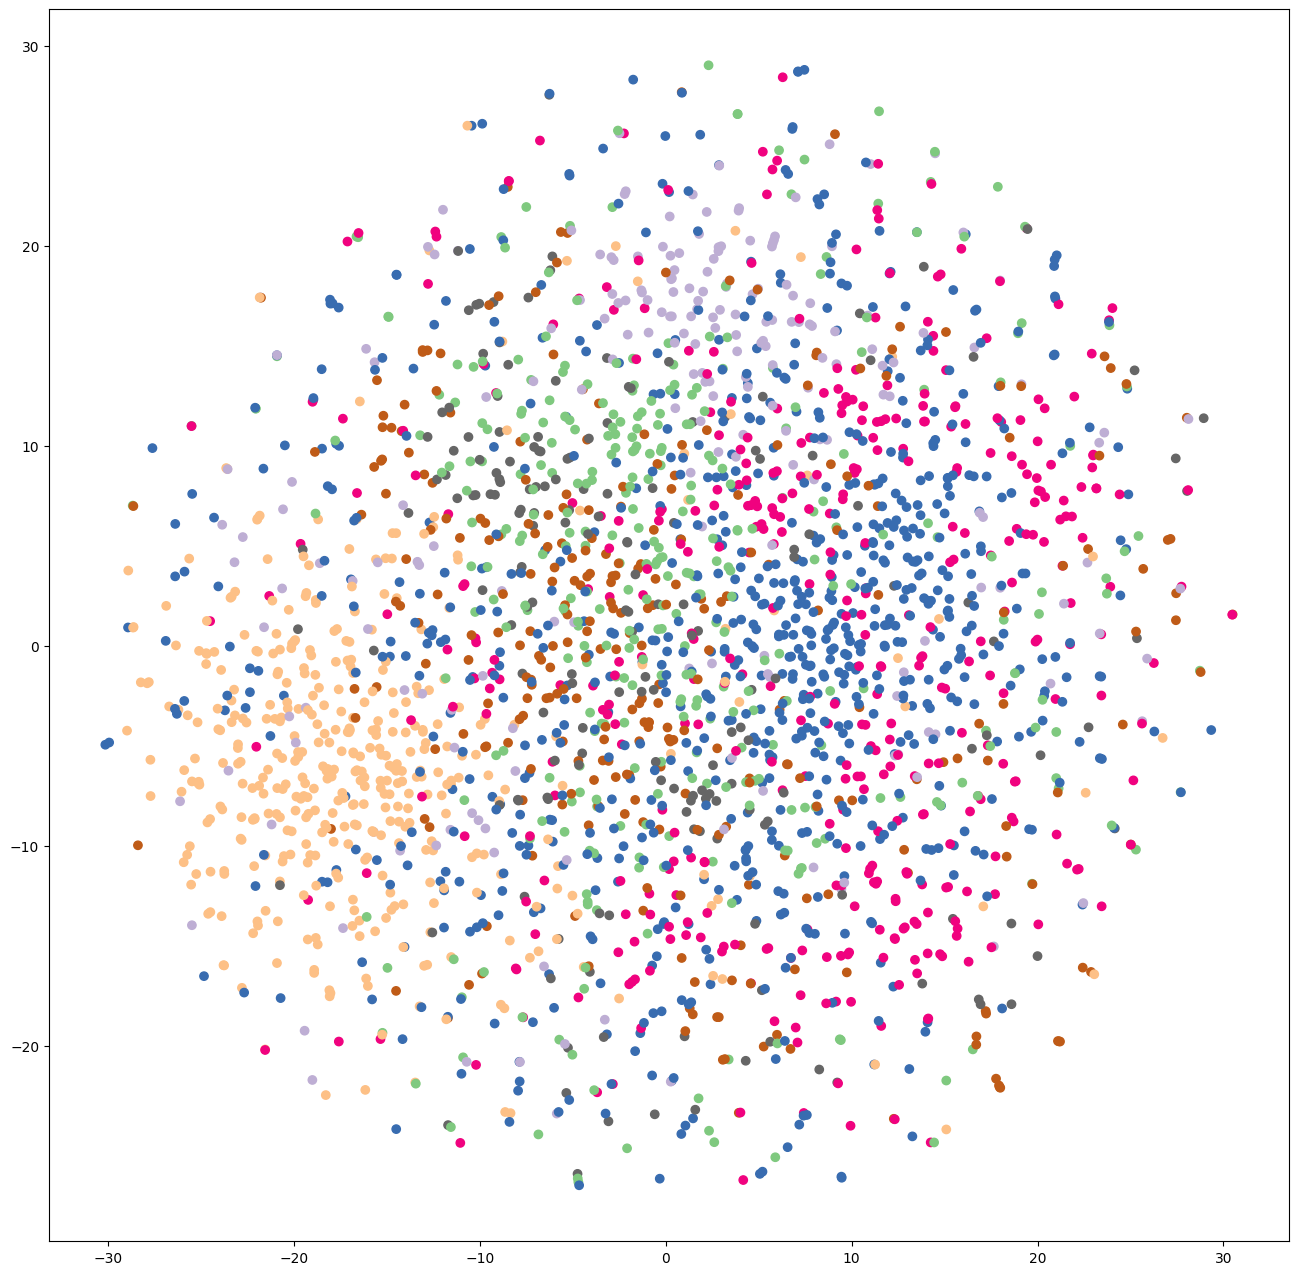

In [6]:
embedding = graph_model().detach()

fig = plt.figure(figsize = (16, 16))
ax = fig.add_subplot(111)
tsne_results = TSNE(n_components = 2).fit_transform(embedding)
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c = data.y, cmap=cm.Accent)

## Classification using the embeddings

In [7]:
hidden_channels = 256
num_layers = 3
dropout = 0.5
learning_rate_mlp = 0.01
epochs_mlp = 50

In [8]:
class MLPModel(Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int, num_layers: int, dropout: float) -> None:
        super().__init__()

        self._linear_layers = torch.nn.ModuleList()
        self._linear_layers.append(torch.nn.Linear(in_channels, hidden_channels))
        self._batchnorm_layers = torch.nn.ModuleList()
        self._batchnorm_layers.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self._linear_layers.append(torch.nn.Linear(hidden_channels, hidden_channels))
            self._batchnorm_layers.append(torch.nn.BatchNorm1d(hidden_channels))
        self._linear_layers.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self) -> None:
        for lin in self._linear_layers:
            lin.reset_parameters()
        for bn in self._batchnorm_layers:
            bn.reset_parameters()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i, lin in enumerate(self._linear_layers[:-1]):
            x = lin(x)
            x = self._batchnorm_layers[i](x)
            x = torch.nn.functional.relu(x)
            x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)
        x = self._linear_layers[-1](x)
        return torch.log_softmax(x, dim=-1)
    
def train(model: MLPModel, x: torch.Tensor, y_true: torch.Tensor, train_mask: torch.Tensor, optimizer: torch.optim.Optimizer) -> float:
    model.train()

    optimizer.zero_grad()
    out = model(x[train_mask])
    loss = torch.nn.functional.nll_loss(out, y_true[train_mask])
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def test(model: MLPModel, x: torch.Tensor, y_true: torch.Tensor, mask: torch.Tensor) -> float:
    model.eval()

    out = model(x[mask])
    y_pred = out.argmax(dim = -1)
    return torch.sum(y_pred == y_true[mask]) / y_pred.size(0)

### Classification using only the embeddings

In [9]:
x = embedding
model = MLPModel(x.size(-1), hidden_channels, dataset.num_classes, num_layers, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate_mlp)

In [10]:
for epoch in range(1, epochs_mlp + 1):
    loss = train(model, x, data.y, data.train_mask, optimizer)
    train_accuracy = test(model, x, data.y, data.train_mask)
    test_accuracy = test(model, x, data.y, data.test_mask)
    print(
        f"Epoch: {epoch:02d}",
        f"Loss: {loss:.4f}",
        f"Train accuracy: {100 * train_accuracy:.2f}%",
        f"Test accuracy: {100 * test_accuracy:.2f}%"
    )

Epoch: 01 Loss: 1.9990 Train accuracy: 45.20% Test accuracy: 44.60%
Epoch: 02 Loss: 1.5258 Train accuracy: 56.46% Test accuracy: 52.40%
Epoch: 03 Loss: 1.3622 Train accuracy: 59.02% Test accuracy: 52.40%
Epoch: 04 Loss: 1.2375 Train accuracy: 63.16% Test accuracy: 53.40%
Epoch: 05 Loss: 1.1761 Train accuracy: 66.56% Test accuracy: 55.10%
Epoch: 06 Loss: 1.1051 Train accuracy: 65.81% Test accuracy: 55.60%
Epoch: 07 Loss: 1.0953 Train accuracy: 66.80% Test accuracy: 54.90%
Epoch: 08 Loss: 1.0649 Train accuracy: 67.30% Test accuracy: 56.00%
Epoch: 09 Loss: 1.0455 Train accuracy: 68.87% Test accuracy: 55.80%
Epoch: 10 Loss: 1.0001 Train accuracy: 69.54% Test accuracy: 55.90%
Epoch: 11 Loss: 0.9634 Train accuracy: 69.87% Test accuracy: 55.50%
Epoch: 12 Loss: 0.9808 Train accuracy: 70.20% Test accuracy: 54.90%
Epoch: 13 Loss: 0.9606 Train accuracy: 72.10% Test accuracy: 54.70%
Epoch: 14 Loss: 0.9252 Train accuracy: 72.76% Test accuracy: 54.80%
Epoch: 15 Loss: 0.9049 Train accuracy: 73.84% Te

### Classification using embeddings and features

In [11]:
x = torch.cat([data.x, embedding], dim = -1)
model = MLPModel(x.size(-1), hidden_channels, dataset.num_classes, num_layers, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate_mlp)

In [12]:
for epoch in range(1, epochs_mlp + 1):
    loss = train(model, x, data.y, data.train_mask, optimizer)
    train_accuracy = test(model, x, data.y, data.train_mask)
    test_accuracy = test(model, x, data.y, data.test_mask)
    print(
        f"Epoch: {epoch:02d}",
        f"Loss: {loss:.4f}",
        f"Train accuracy: {100 * train_accuracy:.2f}%",
        f"Test accuracy: {100 * test_accuracy:.2f}%"
    )

Epoch: 01 Loss: 2.1696 Train accuracy: 48.51% Test accuracy: 41.60%
Epoch: 02 Loss: 1.3056 Train accuracy: 77.90% Test accuracy: 67.30%
Epoch: 03 Loss: 0.8189 Train accuracy: 87.83% Test accuracy: 71.70%
Epoch: 04 Loss: 0.5485 Train accuracy: 93.63% Test accuracy: 74.70%
Epoch: 05 Loss: 0.3844 Train accuracy: 96.27% Test accuracy: 76.60%
Epoch: 06 Loss: 0.2602 Train accuracy: 97.52% Test accuracy: 78.20%
Epoch: 07 Loss: 0.1877 Train accuracy: 98.68% Test accuracy: 77.70%
Epoch: 08 Loss: 0.1305 Train accuracy: 99.42% Test accuracy: 77.10%
Epoch: 09 Loss: 0.0940 Train accuracy: 99.67% Test accuracy: 77.30%
Epoch: 10 Loss: 0.0645 Train accuracy: 99.83% Test accuracy: 77.30%
Epoch: 11 Loss: 0.0556 Train accuracy: 99.92% Test accuracy: 77.10%
Epoch: 12 Loss: 0.0349 Train accuracy: 100.00% Test accuracy: 76.80%
Epoch: 13 Loss: 0.0350 Train accuracy: 100.00% Test accuracy: 76.60%
Epoch: 14 Loss: 0.0228 Train accuracy: 100.00% Test accuracy: 76.80%
Epoch: 15 Loss: 0.0171 Train accuracy: 100.00